tensor(1.5565, grad_fn=<MseLossBackward0>)
tensor(1.3910, grad_fn=<MseLossBackward0>)
tensor(1.5636, grad_fn=<MseLossBackward0>)
tensor(1.2712, grad_fn=<MseLossBackward0>)
tensor(1.4130, grad_fn=<MseLossBackward0>)
tensor(1.4045, grad_fn=<MseLossBackward0>)
tensor(1.4039, grad_fn=<MseLossBackward0>)
tensor(1.3341, grad_fn=<MseLossBackward0>)
tensor(1.2630, grad_fn=<MseLossBackward0>)
tensor(1.2952, grad_fn=<MseLossBackward0>)
tensor(1.4137, grad_fn=<MseLossBackward0>)
tensor(1.3298, grad_fn=<MseLossBackward0>)
tensor(1.3449, grad_fn=<MseLossBackward0>)
tensor(1.2236, grad_fn=<MseLossBackward0>)
tensor(1.3880, grad_fn=<MseLossBackward0>)
tensor(1.1642, grad_fn=<MseLossBackward0>)
tensor(1.3505, grad_fn=<MseLossBackward0>)
tensor(1.3263, grad_fn=<MseLossBackward0>)
tensor(1.3447, grad_fn=<MseLossBackward0>)
tensor(1.3276, grad_fn=<MseLossBackward0>)
tensor(1.2152, grad_fn=<MseLossBackward0>)
tensor(1.2300, grad_fn=<MseLossBackward0>)
tensor(1.2473, grad_fn=<MseLossBackward0>)
tensor(1.05

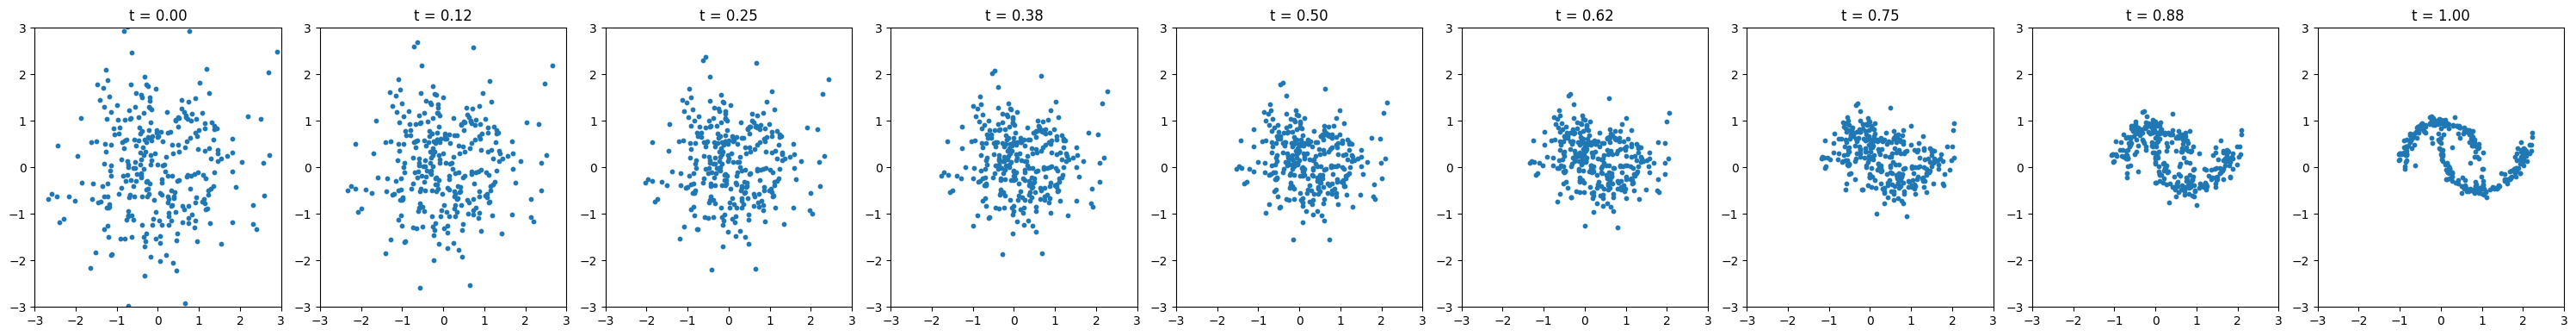

In [3]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
class Flow(nn.Module):
    def __init__(self, dim: int=2, hidden_dim: int=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden_dim), nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ELU(),
            nn.Linear(hidden_dim, dim)
        )
    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat([x, t], dim=-1))
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        dt = t_end - t_start
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        x_mid = self.forward(x_t, t_start) * (dt / 2) + x_t
        x_next = self.forward(x_mid, t_start + dt / 2) * dt + x_t
        return x_next
flow = Flow()
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for iter in range(10000):
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    optimizer.zero_grad()
    loss = loss_func(flow(x_t, t), dx_t)
    loss.backward()
    optimizer.step()
    if iter % 100:
        print(loss)

x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4))
time_steps = torch.linspace(0, 1.0, n_steps + 1) 
axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x, time_steps[i], time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')
    axes[i + 1].set_xlim(-3.0, 3.0)
    axes[i + 1].set_ylim(-3.0, 3.0)

plt.tight_layout()
plt.show()


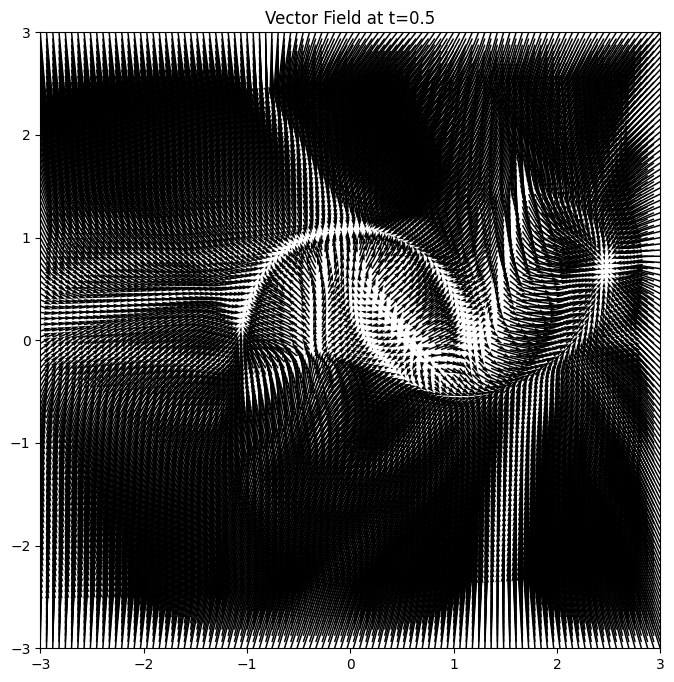

In [9]:
x = torch.linspace(-3, 3, 100)
y = torch.linspace(-3, 3, 100)
X, Y = torch.meshgrid(x, y)
xy = torch.stack([X.flatten(), Y.flatten()], dim=1)

t = torch.ones(len(xy), 1) * 1
with torch.no_grad():
    dxy = flow(xy, t)

plt.figure(figsize=(8, 8))
plt.quiver(xy[:, 0].numpy(), xy[:, 1].numpy(), 
          dxy[:, 0].numpy(), dxy[:, 1].numpy(),
          scale=60)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.title('Vector Field at t=0.5')
plt.show()
